In [27]:
# Importing all the necessary libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda
from nltk.translate.bleu_score import corpus_bleu

In [28]:
# Setting up the input and output directory
INPUT_DIR = '/content/input'
OUTPUT_DIR = '/content/output'
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [29]:
# VGG16 model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [30]:
image_features = {}
# 'images' is the directory path where all the images are present
img_dir = os.path.join(INPUT_DIR, 'images')

for img_name in tqdm(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    image_feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    image_features[image_id] = image_feature

  0%|          | 0/42 [00:00<?, ?it/s]

In [31]:
# Store the image features in img_features.pkl file
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [32]:
# the load the features from img_features.pkl file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [33]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [34]:
image_to_captions_mapping = defaultdict(list)
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    image_id = image_id.split('.')[0]
    caption = " ".join(captions)
    image_to_captions_mapping[image_id].append(caption)
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/9 [00:00<?, ?it/s]

Total number of captions: 9


In [35]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            caption = caption.replace('\s+', ' ')
            caption = ' '.join([word for word in caption.split() if len(word) >= 1])
            captions[i] = caption

In [36]:
image_to_captions_mapping['img5']

[' A man with blue jacket staring at the mountains on a sunny day']

In [37]:
clean(image_to_captions_mapping)

In [38]:
image_to_captions_mapping['img7']

['a women with a cream beanie in a tent near snow covered mountains']

In [39]:
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [40]:
all_captions[:10]

['a man with yellow jacket drinking tea while hiking in snow',
 'a man with blue cap is walking up the mountains',
 'a man with red jacket and a beanie is on top of the snow mountain',
 'a man with blue jacket staring at the mountains on a sunny day',
 'a man with a hat along with two donkeys walking',
 'a women with a cream beanie in a tent near snow covered mountains',
 'a group of people chitchatting sitting near mountains',
 'a man with red shirt standing on one of the peak of the hill',
 'a boy with blue shirt and red shorts walking uphill on a good sunny day']

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [42]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [43]:
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 52
Maximum Caption Length: 15


In [44]:
image_ids = list(image_to_captions_mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [45]:
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys:
            captions = image_to_captions_mapping[image_id]
            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1_batch.append(features[image_id][0])
                    X2_batch.append(in_seq)
                    y_batch.append(out_seq)
                    batch_count += 1
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

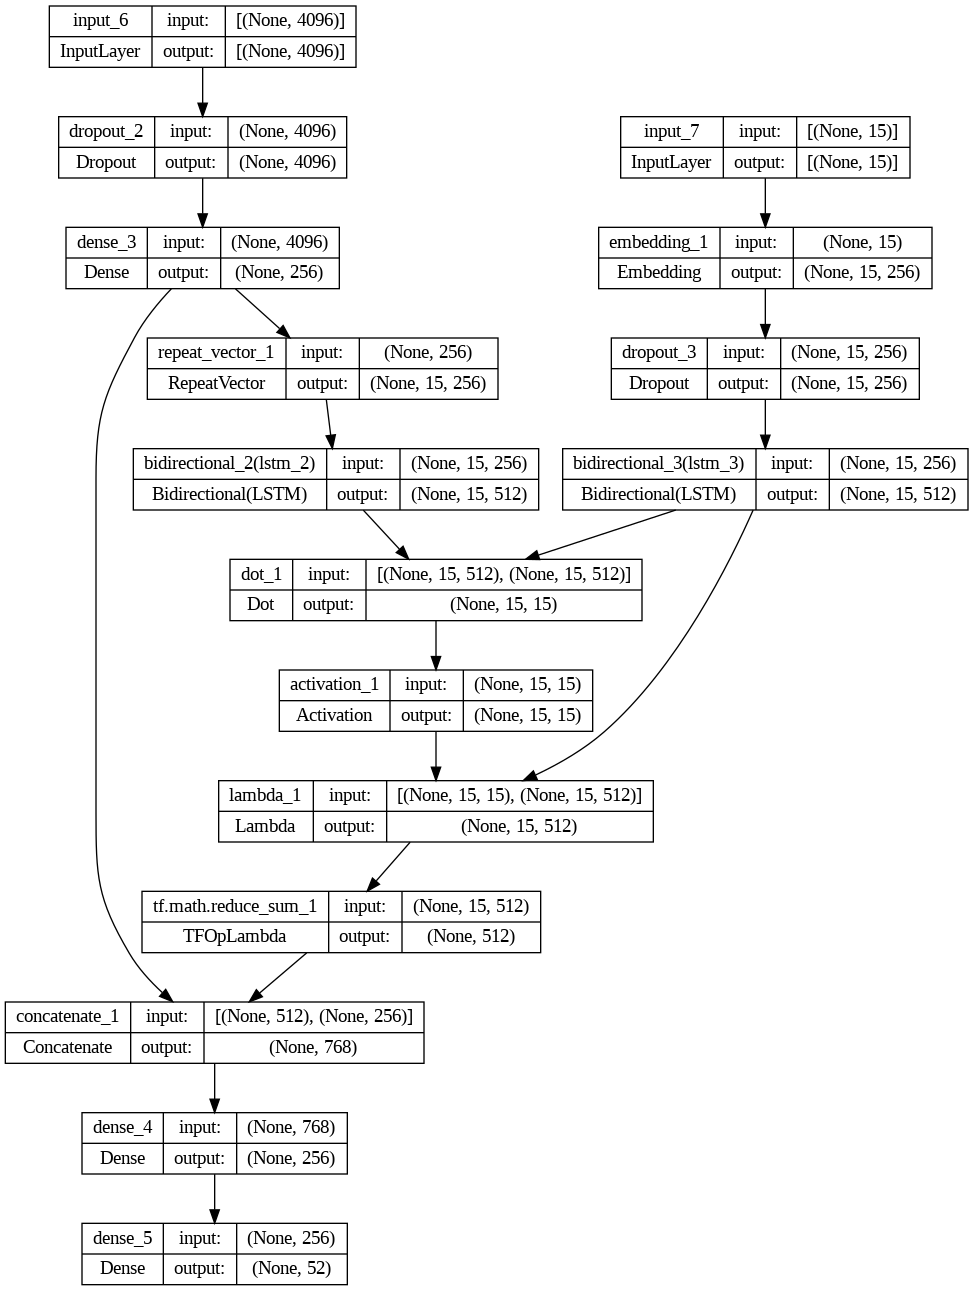

In [46]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

attention = Dot(axes=[2, 2])([fe2_projected, se3])

attention_scores = Activation('softmax')(attention)

attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

context_vector = tf.reduce_sum(attention_context, axis=1)

decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [47]:
epochs = 20
batch_size = 32
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/5
1/1 [==============================] - 12s 12s/step - loss: 5.5478 - val_loss: 3.8933
Epoch 2/5
1/1 [==============================] - 0s 372ms/step - loss: 4.0723 - val_loss: 4.0165
Epoch 3/5
1/1 [==============================] - 0s 391ms/step - loss: 3.3379 - val_loss: 4.2582
Epoch 4/5
1/1 [==============================] - 0s 381ms/step - loss: 3.3330 - val_loss: 4.5096
Epoch 5/5
1/1 [==============================] - 0s 372ms/step - loss: 3.0632 - val_loss: 4.6640


In [48]:
model.save(OUTPUT_DIR+'/mymodel.h5')

In [49]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [50]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    caption = 'startseq'
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        predicted_index = np.argmax(yhat)
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        caption += " " + predicted_word
        if predicted_word is None or predicted_word == 'endseq':
            break

    return caption

In [51]:
actual_captions_list = []
predicted_captions_list = []
for key in tqdm(test):
    actual_captions = image_to_captions_mapping[key]
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    actual_captions_words = [caption.split() for caption in actual_captions]
    predicted_caption_words = predicted_caption.split()
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1 [00:00<?, ?it/s]

BLEU-1: 0.062500
BLEU-2: 0.000000


In [63]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('CAPTION: ')
    for caption in captions:
        print(caption)
    plt.imshow(image)

CAPTION: 
a man with red jacket and a beanie is on top of the snow mountain


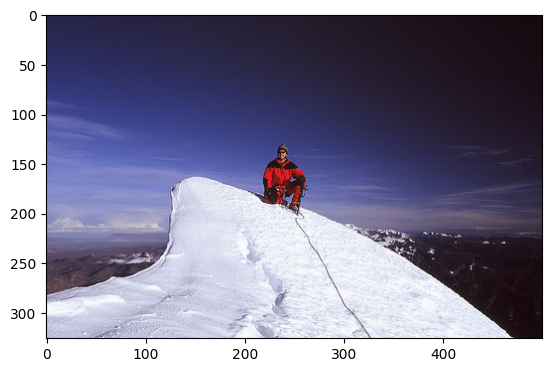

In [64]:
generate_caption("img4.jpg")

---------------------Caption---------------------
a women with a cream beanie in a tent near snow covered mountains


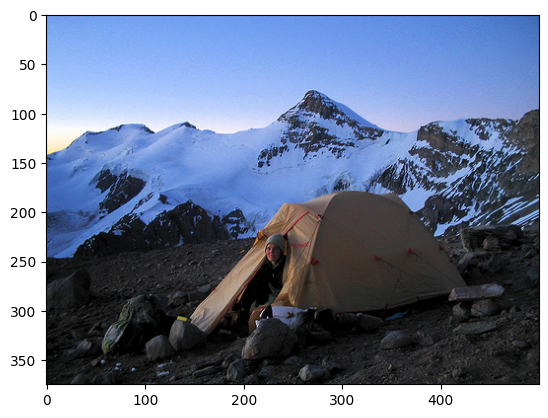

In [54]:
generate_caption("img7.jpg")

CAPTION: 
a man with red shirt standing on one of the peak of the hill


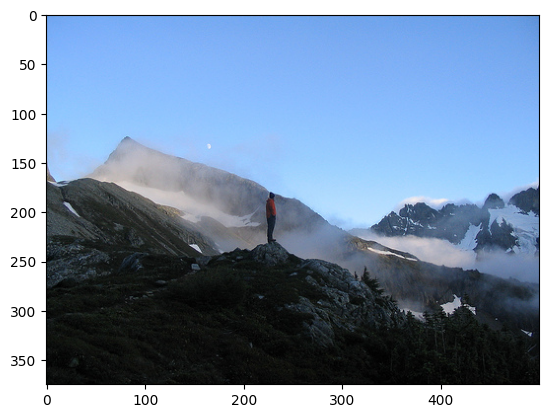

In [67]:
generate_caption("img9.jpg")
